<a href="https://colab.research.google.com/github/Playmen998/Data-Analysis/blob/master/Reporting_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание и цели работы

Вы работаете в бухгалтерии компании, занимающейся продажей запчастей для мотоциклов. Компания управляет тремя складами в большом мегаполисе.

Недавно вы научились манипулировать данными и строить графики и предлагаете помочь своему коллеге проанализировать данные о прошлых продажах. Ваш коллега хочет зафиксировать продажи по способу оплаты. Ей также необходимо знать среднюю цену за единицу каждой линейки продуктов.

Данные о продажах имеют следующие поля:  
- "date" - дата с июня по август 2021 года.
- "warehouse" - компания управляет тремя складами: North, Central, and West.
- "client_type" - есть два типа клиентов: Retail and Wholesale.
- "product_line" - тип приобретаемых товаров.
- "quantity" - сколько товаров было куплено.
- "unit_price" - цена проданного товара.
- "total" - общий объем продаж = quantity * unit_price.
- "payment" - способ оплаты клиентом:: Cash, Credit card, Transfer.

Создайте отчет, чтобы ответить на вопросы вашего коллеги. Включают:

1. Каков общий объем продаж для каждого способа оплаты? + визуализация 
2. Какова средняя цена за единицу каждой линейки продуктов? + визуализация 
3. Дальнейшее исследование (например, средняя стоимость покупки по типу клиента, общая стоимость покупки по продуктовой линейке и т. д.)
4. Подведите итоги.

Ссылка на таблицу https://drive.google.com/file/d/1Mb9DH4tjfWK5Cb4-G3le4zly1HyCk4YM/view?usp=share_link

In [1]:
!gdown 1Mb9DH4tjfWK5Cb4-G3le4zly1HyCk4YM

Downloading...
From: https://drive.google.com/uc?id=1Mb9DH4tjfWK5Cb4-G3le4zly1HyCk4YM
To: /content/sales_data.csv
100% 67.3k/67.3k [00:00<00:00, 14.5MB/s]


#Разведывательный анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/sales_data.csv')

In [4]:
df.head()

,date,warehouse,client_type,product_line,quantity,unit_price,total,payment
0,2021-06-01,Central,Retail,Miscellaneous,8,16.85,134.83,Credit card
1,2021-06-01,North,Retail,Breaking system,9,19.29,173.61,Cash
2,2021-06-01,North,Retail,Suspension & traction,8,32.93,263.45,Credit card
3,2021-06-01,North,Wholesale,Frame & body,16,37.84,605.44,Transfer
4,2021-06-01,Central,Retail,Engine,2,60.48,120.96,Credit card


In [5]:
df.shape

(1000, 8)

В таблице 1000 строк и 8 столбцов

In [6]:
df.dtypes

date             object
warehouse        object
client_type      object
product_line     object
quantity          int64
unit_price      float64
total           float64
payment          object
dtype: object

Колонка с датами представлена в типе данных object переведем в timestamp. Остальные колонки имеют правильный тип данных

In [7]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [8]:
df.isna().mean()

date            0.0
warehouse       0.0
client_type     0.0
product_line    0.0
quantity        0.0
unit_price      0.0
total           0.0
payment         0.0
dtype: float64

В данных нет пропусков, отлично!

In [9]:
df.describe()

,quantity,unit_price,total
count,1000.000000,1000.000000,1000.000000
mean,9.395000,30.322040,289.113000
std,9.659207,12.256488,345.227596
min,1.000000,10.030000,10.350000
25%,4.000000,21.085000,93.687500
50%,6.500000,28.570000,178.360000
75%,10.000000,37.917500,321.690000
max,40.000000,66.620000,2546.330000


Достаточно большие отклонения в столбце "total" max значения от 75% процентиля, скорее всего это из-за выбросов

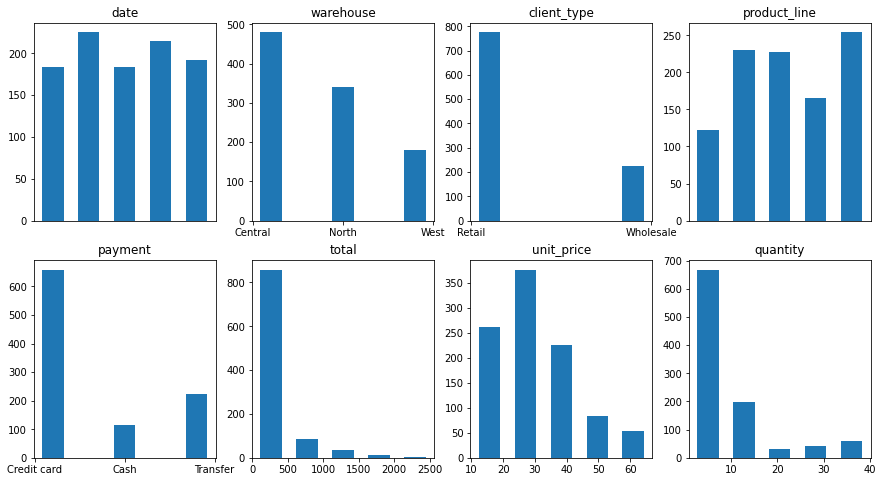

In [10]:
fig, axes = plt.subplots(2, 4)

fig.set_figheight(8)
fig.set_figwidth(15)

x = 0
y = 0
for i in range(df.shape[1]):
  if i < 4:
    if (i == 0) | (i == 3):
      axes[x][y].get_xaxis ().set_visible( False )
    axes[x][y].hist(df.iloc[: , i], bins = 5, rwidth = 0.6)
    axes[x][y].set_title(df.columns[i])
    y += 1
  else:
    y -= 1
    x = 1
    axes[x][y].hist(df.iloc[: , i], bins = 5, rwidth = 0.6)
    axes[x][y].set_title(df.columns[i])
    
plt.show()

Проанализируем распределения каждого столбца:
+ В "date" распределение напоминает равномерное, тем неменее некоторые bins отклоняются
+ В "warehouse" присутствует больше всего значений "Central" дальше идут "North" и "West" соответственно
+ В "client_type" значение "Retail" имеет гораздо больше наблюдений, чем в "Wholesale" 
+ В "payment" значение "Credit card" имеет больше наблюдений, чем "Cash" и "transfer"
+ Столбцы "total" , "unit_price", "quantity" имеют распределения с жирным хвостом

In [11]:
df['product_line'].value_counts()

Breaking system          230
Suspension & traction    228
Electrical system        193
Frame & body             166
Miscellaneous            122
Engine                    61
Name: product_line, dtype: int64

Самые большие значения в столбце "product_line": "Breaking system", "Suspension & traction", "Electrical system"

# Анализ данных

## Общий объем продаж для каждого способа оплаты

In [12]:
df.head()

,date,warehouse,client_type,product_line,quantity,unit_price,total,payment
0,2021-06-01,Central,Retail,Miscellaneous,8,16.85,134.83,Credit card
1,2021-06-01,North,Retail,Breaking system,9,19.29,173.61,Cash
2,2021-06-01,North,Retail,Suspension & traction,8,32.93,263.45,Credit card
3,2021-06-01,North,Wholesale,Frame & body,16,37.84,605.44,Transfer
4,2021-06-01,Central,Retail,Engine,2,60.48,120.96,Credit card


In [13]:
df.groupby('payment')['total'].agg(['sum','count','median'])

,sum,count,median
payment,,,
Cash,19199.10,116,139.135
Credit card,110271.57,659,143.580
Transfer,159642.33,225,599.270


Больше всего получено дохода через Transfer, медианное значение оплаты в несколько раз выше, чем через оплату Credit card и Cash, однако кол-во переводов небольшое, возможно это коммерческие компании, которые совершают оптовые покупки  
Платежи через Cash имеют самое маленькое число по доходу, кол-во сделок,медианного значения оплаты и сильно отстает от Credit card и Transfer

In [14]:
df.groupby(['payment','client_type'])['total'].agg(['sum','count','median'])

,,sum,count,median
payment,client_type,,,
Cash,Retail,19199.10,116,139.135
Credit card,Retail,110271.57,659,143.580
Transfer,Wholesale,159642.33,225,599.270


Наша гипотеза подтвердилась: через платеж Transfer совершаются оптовые покупки, через Cash и Credit card совершаются покупки в розницу

In [15]:
payment_total = df.groupby('payment')['total'].agg(['sum','count','median']).reset_index()

Построим визуализацию

Text(0.5, 1.0, 'Кол-во сделок')

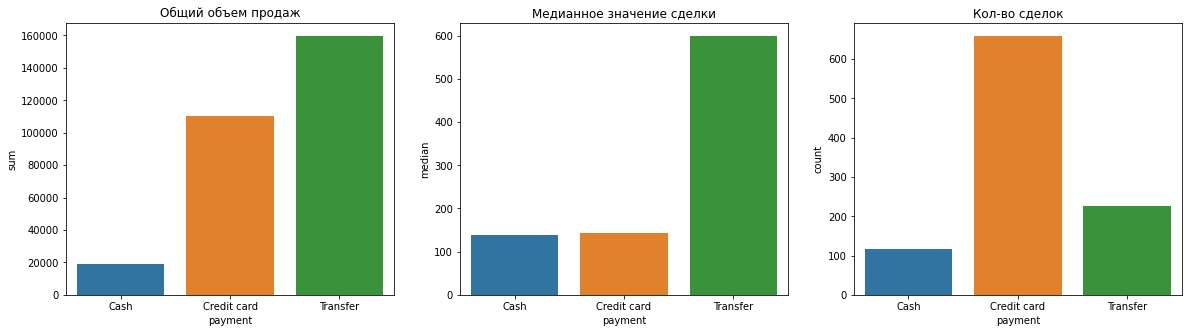

In [16]:
fig, axs = plt.subplots(ncols=3)
fig.set_figheight(5)
fig.set_figwidth(20)
sns.barplot(x='payment', y='sum', data=payment_total, ax=axs[0])
axs[0].set_title("Общий объем продаж")

sns.barplot(x='payment', y='median', data=payment_total, ax=axs[1])
axs[1].set_title("Медианное значение сделки")

sns.barplot(x='payment',y='count', data=payment_total, ax=axs[2])
axs[2].set_title("Кол-во сделок")

## Cредняя цена за единицу каждой линейки продуктов

In [17]:
df.head()

,date,warehouse,client_type,product_line,quantity,unit_price,total,payment
0,2021-06-01,Central,Retail,Miscellaneous,8,16.85,134.83,Credit card
1,2021-06-01,North,Retail,Breaking system,9,19.29,173.61,Cash
2,2021-06-01,North,Retail,Suspension & traction,8,32.93,263.45,Credit card
3,2021-06-01,North,Wholesale,Frame & body,16,37.84,605.44,Transfer
4,2021-06-01,Central,Retail,Engine,2,60.48,120.96,Credit card


In [18]:
df.groupby("product_line")['unit_price'].agg(['median','mean']).sort_values(by = 'mean', ascending = False)

,median,mean
product_line,,
Engine,59.820,60.091803
Frame & body,43.105,42.832229
Suspension & traction,33.730,33.969868
Electrical system,25.530,25.585130
Miscellaneous,22.480,22.810738
Breaking system,17.380,17.740522


Самые дорогие товары находятся в категориях Engine и Frame & body, также стоит сказать о том, что среднее значение не сильно отличается от медианного, значит среднее значение можно объективно использовать, как метрику для анализа  

In [19]:
product_price = df.groupby("product_line")['unit_price'].agg(['median','mean']).sort_values(by = 'mean', ascending = False).reset_index()

Построим визуализацию

Text(0.5, 1.0, 'Средняя стоимость товара')

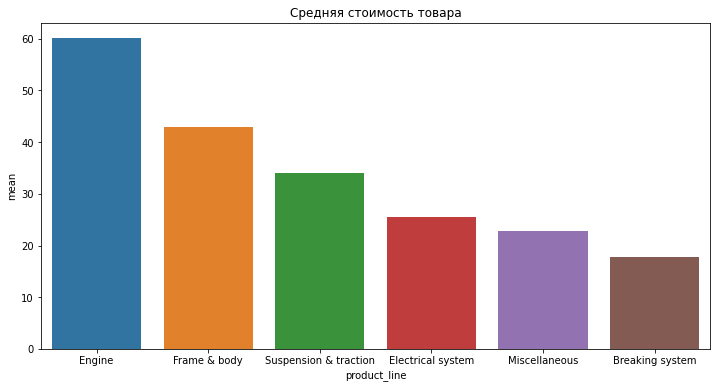

In [20]:
fig, axs = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(12)
sns.barplot(x='product_line',y='mean', data=product_price)
axs.set_title("Средняя стоимость товара")

In [21]:
df.groupby('product_line')[['quantity','total']].agg({'total' : 'median', 'quantity' : 'sum'}).sort_values(by = 'total', ascending = False)

,total,quantity
product_line,,
Engine,414.330,627
Frame & body,272.605,1619
Suspension & traction,228.715,2145
Electrical system,153.830,1698
Miscellaneous,147.140,1176
Breaking system,95.770,2130


Самый большой доход приносит категория товаров Engine   
Чаще всего покупают товары из категорий: Suspension, Breaking system, Frame & body, Electrical system	

Посчитаем процентное соотношения товаров на каждом складу. Эти выводы помогут понять, какие категории товаров чаще покупают, что позволит понять сколько товаров, каких категорий стоит отгружать на склад

In [22]:
place_product = df.groupby(['warehouse','product_line'])['quantity'].sum().reset_index()

In [23]:
place_total_sum = place_product.groupby('warehouse')['quantity'].sum().reset_index().rename(columns = {'quantity':'sum_quantity'})

In [24]:
place_product = place_product.merge(place_total_sum, on = 'warehouse', how = 'left', )

In [25]:
place_product['pct_total'] = ((place_product['quantity'] * 100 ) / place_product['sum_quantity']).round(2)

In [26]:
place_product = place_product.sort_values(by=['warehouse', 'pct_total'], ascending = False)

In [27]:
place_product = place_product.drop(['quantity','sum_quantity'], axis = 1)

In [28]:
warehouses = place_product['warehouse'].unique()

In [29]:
import seaborn as sns
cm = sns.dark_palette("green", as_cmap=True)

In [30]:
def palette(warehouses):
    return place_product[place_product['warehouse'] == warehouses].style.background_gradient(cmap=cm, subset=['pct_total'])

In [31]:
palette(warehouses[0])

,warehouse,product_line,pct_total
12,West,Breaking system,31.040000
17,West,Suspension & traction,18.530000
16,West,Miscellaneous,16.050000
13,West,Electrical system,15.680000
15,West,Frame & body,15.240000
14,West,Engine,3.470000


В районе склада Central больше всего было совершенно покупок товаров из категорий Breaking system, Suspension & traction, Electrical system	  

In [32]:
palette(warehouses[1])

,warehouse,product_line,pct_total
11,North,Suspension & traction,26.610000
9,North,Frame & body,20.740000
7,North,Electrical system,18.650000
6,North,Breaking system,18.590000
10,North,Miscellaneous,11.650000
8,North,Engine,3.750000


В районе склада North больше всего было совершенно покупок товаров из категорий Suspension & traction, Frame & body, Electrical system

In [33]:
palette(warehouses[2])

,warehouse,product_line,pct_total
0,Central,Breaking system,22.620000
5,Central,Suspension & traction,21.650000
1,Central,Electrical system,18.510000
3,Central,Frame & body,15.420000
4,Central,Miscellaneous,11.880000
2,Central,Engine,9.920000


В районе склада West больше всего было совершенно покупок товаров из категорий Breaking system, Suspension & traction, Miscellaneous

# Выводы

1. Наш магазин по продажи запчастей для мотоциклов получает больше всего дохода через платежи Transfer, т.к. это оптовые продажи.  
Через платежи Cash магазин получает наименьшее кол-во дохода, также суммарно Cash сильно отстает от Transfer и Credit  
Через платежи Credit и Cash совершаются покупки в розницу
2. Самые дорогие по цене товары находятся в категориях Engine и Frame & body
3. Самый большой доход приносит категория товаров Engine
4. Чаще всего покупают товары из категорий: Suspension, Breaking system, Frame & body, Electrical system
5. Процентное соотношения товаров на каждом складе:
  + Склад Central имеет больше всего покупок товаров из категорий Breaking system, Suspension & traction, Electrical system
  + Склад North имеет больше всего покупок товаров из категорий Suspension & traction, Frame & body, Electrical system
  + Склад West имеет больше всего покупок товаров из категорий Breaking system, Suspension & traction, Miscellaneous